# This code computes the signal-to-noise to $f_{NL}$ from the matter bispectrum with and without non-Gaussian noise and compares them to simulations

### import packages

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from PrimordialPowerspectrum import *
from PrimordialBispectra import *
from SecondaryPolyspectra import *
from scipy.interpolate import InterpolatedUnivariateSpline as interpolate
import vegas
from tqdm import tqdm
from joblib import Parallel, delayed

%config InlineBackend.figure_format = 'svg' 
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams.update({'font.size': 16})

## Choose the redshift to analyse and load the power spectra

z: 0


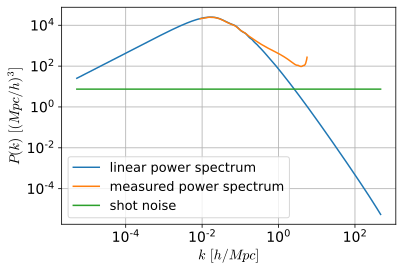

In [4]:
zs = [0,3,10,30,50,100]

zi = 0 #CHOOSE THE INDEX OF THE ABOVE REDSHIFTS HERE
z = zs[zi]
print("z:",z)

PLin = np.loadtxt("PLinear.dat")
kLin = PLin[:,0]
PLin = PLin[:,zi+1]
PLinInt = interpolate(kLin,PLin,ext=2)

if z == 10 :
    PNonLin = np.load('Pks_z10.npy')
    kNonLin = PNonLin[0,:]
    PNonLin = PNonLin[1:].mean(0)
    PNonLinInt = interpolate(kNonLin,PNonLin,ext=0)
    
    kF = 2.*np.pi/250.
    nbar = 512.**3 / 250.**3
    
elif z > 10:
    PNonLin = np.loadtxt('PHalo.dat')
    kNonLin = PNonLin[:,0]
    PNonLin = PNonLin[:,zi+1]
    PNonLinInt = interpolate(kNonLin,PNonLin,ext=0)
    
    kF = 2.*np.pi/250.
    nbar = 512**3 / 250**3
    
else:
    PNonLin = np.loadtxt('PNonLinearQuijote.dat')
    kNonLin = PNonLin[:,0]
    if z == 0:
        PNonLin = PNonLin[:,1]
    if z == 3:
        PNonLin = PNonLin[:,-1]
    PNonLinInt = interpolate(kNonLin,PNonLin,ext=0)

    kF = 2.*np.pi/1000.
    nbar = 512**3 / 1000**3
    
plt.loglog(kLin,PLin,label='linear power spectrum')
plt.loglog(kNonLin,PNonLin,label='measured power spectrum')
plt.loglog(kLin,np.ones_like(kLin)/nbar,label='shot noise')
plt.xlabel("$k$ $[h/Mpc]$")
plt.ylabel("$P(k)$ $[(Mpc/h)^3]$")
plt.grid()
plt.legend(fontsize=13)
plt.show()

### We compute the non-linear scale using $$k_{NL}(z) = \left[ \frac{1}{6\pi^2}\int_0^\infty dk \; P_\delta^L(k,z) \right]^{-1/2}$$

In [5]:
kNL = (np.trapz(PLin,kLin)/6/np.pi**2)**-.5
print(f"kNL @ z={z}:",kNL)

kNL @ z=0: 0.16703188015479575


### To turn the primordial bispectrum into a matter bispectrum we also need the transfer function: $$B^{pnG}_\delta(z;k_1,k_2,k_3) = \left(\prod_{i=1}^3 \mathcal{M}(k_i,z) \right) B_\zeta(k_1,k_2,k_3)$$

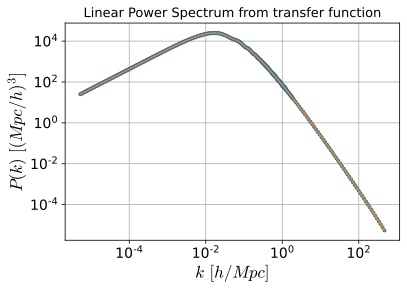

In [6]:
transfer_data = np.genfromtxt("LinearTransfer.dat")
kh_transfer = transfer_data[:,0]
Tc = transfer_data[:,1:]
Tc = Tc[:,zi]
k_transfer = kh_transfer*h
TFint = interpolate(kh_transfer,Tc)
Pprim = P(k_transfer)

plt.loglog(kh_transfer,h**3 * Pprim * Tc**2,".")
plt.loglog(kLin,PLin)
plt.xlabel("$k$ $[h/Mpc]$",fontsize=17)
plt.ylabel("$P(k)$ $[(Mpc/h)^3]$",fontsize=17)
plt.title("Linear Power Spectrum from transfer function",fontsize=13)
plt.grid()
plt.show()

### Next we load the simulation data

(7057, 1898)


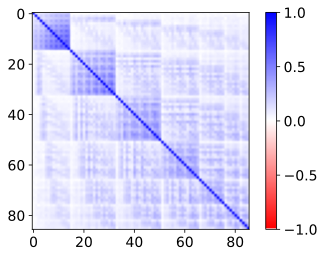

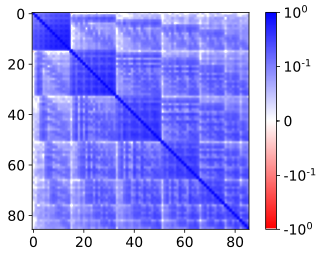

In [7]:
if z == 0:
    kmax = kNL
elif z == 3:
    kmax = 0.5
else:
    kmax = 0.4

if z > 3:
    V123 = np.load("counts_z10.npy")
else:
    V123 = np.load("counts_Quij.npy")

k_tr = V123[:,:3]
N_tr = np.sum(k_tr[:,0]*kF < kmax)
k_tr = k_tr[:N_tr]

for ii, bini in enumerate(V123):
    if bini[0] == bini[1] and bini[1] == bini[2]:
        V123[ii,-1]*=6
    elif bini[0] == bini[1] or bini[1] == bini[2] or bini[0] == bini[2]:
        V123[ii,-1]*=2
        
V123 = V123[:N_tr,-1] * kF**6

VP = 4*np.pi*k_tr*kF
order = np.argsort(k_tr[:,-1],kind='mergesort')

if z > 3:
    Bks = np.load("Bk_z10.npy")
else:
    Bks = np.load(f"Bk_Quijote_z{z}.npy")
    
print(Bks.shape)
    
Cov_Quij = np.cov(Bks.T)

Cov_Quij = Cov_Quij[:N_tr,:N_tr] #choose with or without shot

Cov_Quij_Inv = np.linalg.inv(Cov_Quij)

N_sims = len(Bks)
hartlapfactor = (N_sims - len(Cov_Quij) - 2) / (N_sims - 1)
Cov_Quij_Inv *= hartlapfactor

order = np.argsort(k_tr[:N_tr,-1],kind='mergesort')

Cov_Quij_ordered = Cov_Quij[order,:][:,order]

Cov_GQuij = np.diag(np.diag(Cov_Quij))
Cov_GQuij_Inv = np.linalg.inv(Cov_GQuij)

r_Quij = Cov_Quij / np.outer(np.diag(Cov_Quij),np.diag(Cov_Quij))**.5
r_Quij_ordered = Cov_Quij_ordered / np.outer(np.diag(Cov_Quij_ordered),np.diag(Cov_Quij_ordered))**.5

plt.imshow(r_Quij_ordered,cmap='bwr_r',vmin=-1,vmax=1)
plt.colorbar()
plt.show()

plt.imshow(r_Quij_ordered,cmap='bwr_r',norm=SymLogNorm(linthresh=0.01, linscale=0.01,vmin=-1,vmax=1))
plt.colorbar(ticks=[-1,-0.1,0,0.1,1])
# plt.colorbar()
plt.show()

### We compute the Gaussian covariance matrix

In [8]:
v123sym = np.load("counts_Quij.npy")[:N_tr,-1]* kF**6 # This is the volume with the triangle symmetry factor already included, so we don't have to do that seperately

PNonLin_tr = PNonLinInt(k_tr*kF)
PLin_tr = PLinInt(k_tr*kF)
Cov_Binned = PNonLin_tr.prod(1)
Cov_Binned*=1/v123sym*kF**3 * (2*np.pi)**3
Cov_Binned = np.diag(Cov_Binned)

Cov_Binned_Inv = np.linalg.inv(Cov_Binned)

### To compute the bin-averaged bispectrum we need $$V_{123} = \int_{k_1} d^3 \textbf{q}_1 \int_{k_2}d^3 \textbf{q}_2 \int_{k_3}d^3 \textbf{q}_3 $$

In [9]:
def VIntegrand(k,ka,kb,kc):
    k1 = k[:,0]
    k2 = k[:,1]
    theta1=k[:,2]
    
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta1))
    
    dVol = 4*np.pi * 2*np.pi * k1**2 * k2**2 * np.sin(theta1)
    
    P1prim = P(k1*h)
    P2prim = P(k2*h)
    P3prim = P(k3*h)
    
    dk = 3
    bools = k1 < ka-dk*kF/2
    bools+= k1 > ka+dk*kF/2
    bools+= k2 < kb-dk*kF/2
    bools+= k2 > kb+dk*kF/2
    bools+= k3 < kc-dk*kF/2
    bools+= k3 > kc+dk*kF/2
    
    B = np.ones_like(k1)
    B[bools] = 0
    
    return B * dVol

def VAverage(tr_i,rtol=1e-2,verbose=0):
#     print(tr_i)
    dk = 3
    ka, kb, kc = k_tr[tr_i]*kF

    @vegas.batchintegrand
    def integrandbatch(k):
        return VIntegrand(k,ka,kb,kc)

    integ = vegas.Integrator([[ka-dk*kF/2,ka+dk*kF/2],[kb-dk*kF/2,kb+dk*kF/2],[0,np.pi]])
    
    pre = integ(integrandbatch,nitn=10,neval=1e5,rtol=rtol)
    if verbose!=0:
        print(pre.summary())

    results = integ(integrandbatch,nitn=100,neval=1e5,rtol=rtol)
    if verbose!=0:
        print(results.summary())
        
    mean = results.mean
    rerr = np.abs(results.sdev/mean)
    Q = results.Q
    
    if rerr > rtol:
        results = integ(integrandbatch,nitn=100,neval=1e6,rtol=rtol)
        if verbose!=0:
            print(results.summary())
        
    mean = results.mean
    rerr = np.abs(results.sdev/mean)
    Q = results.Q

    return Q, mean, rerr

Vav = np.array(Parallel(n_jobs=-1,verbose=1)([delayed(VAverage)(i,verbose=0) for i in range(N_tr)]))
V_tr = Vav[:,-2]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:    1.9s finished


### Now choose which shape to compute

In [20]:
BShapes = [BLocal,BEquil,BOrtho]
ShapeLabels = ["Local","Equil","Ortho"]
BShape_n = 0 #choose the shape here!
BShape = BShapes[BShape_n]
print(BShape)

<function BLocal at 0x7fa1dc833b80>


### and compute the bin-average bispectrum  and $$\frac{\partial \hat{B}(k_1,k_2,k_3)}{\partial f_{NL}} = \frac{1}{V_{123}}\int_{k_1} d^3 \textbf{q}_1 \int_{k_2}d^3 \textbf{q}_2 \int_{k_3}d^3 \textbf{q}_3 \frac{\partial B(\textbf{q}_1,\textbf{q}_2,\textbf{q}_3)}{\partial f_{NL}} $$

In [21]:
def BIntegrand(k,ka,kb,kc):
    k1 = k[:,0]
    k2 = k[:,1]
    theta1=k[:,2]
    
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta1))
    
    dVol = 4*np.pi * 2*np.pi * k1**2 * k2**2 * np.sin(theta1)
    
    P1prim = P(k1*h)
    P2prim = P(k2*h)
    P3prim = P(k3*h)
    
    dk = 3
    bools = k1 < ka-dk*kF/2
    bools+= k1 > ka+dk*kF/2
    bools+= k2 < kb-dk*kF/2
    bools+= k2 > kb+dk*kF/2
    bools+= k3 < kc-dk*kF/2
    bools+= k3 > kc+dk*kF/2
    
    TFk1 = TFint(k1)
    TFk2 = TFint(k2)
    TFk3 = TFint(k3)
    
    if BShape_n < 4:
        B = h**6 * TFk1 * TFk2 * TFk3 * BShape(P1prim,P2prim,P3prim)
    else:
        B = h**6 * TFk1 * TFk2 * TFk3 * BShape(k1,k2,k3,mu,2)
    B[bools] = 0
    
    return B * dVol

def BAverage(tr_i,rtol=1e-2,verbose=0):
#     print(tr_i)
    dk = 3
    ka, kb, kc = k_tr[tr_i]*kF
    VVV = V_tr[tr_i]

    @vegas.batchintegrand
    def integrandbatch(k):
        return BIntegrand(k,ka,kb,kc)/VVV

    integ = vegas.Integrator([[ka-dk*kF/2,ka+dk*kF/2],[kb-dk*kF/2,kb+dk*kF/2],[0,np.pi]])
    
    pre = integ(integrandbatch,nitn=10,neval=1e5,rtol=rtol)
    if verbose!=0:
        print(pre.summary())

    results = integ(integrandbatch,nitn=100,neval=1e5,rtol=rtol)
    if verbose!=0:
        print(results.summary())
        
    mean = results.mean
    rerr = np.abs(results.sdev/mean)
    Q = results.Q
    
    if rerr > rtol:
        results = integ(integrandbatch,nitn=100,neval=1e6,rtol=rtol)
        if verbose!=0:
            print(results.summary())
        
    mean = results.mean
    rerr = np.abs(results.sdev/mean)
    Q = results.Q

    return Q, mean, rerr

bav = np.array(Parallel(n_jobs=-1,verbose=1)([delayed(BAverage)(i,verbose=0) for i in range(N_tr)]))
B_tr = bav[:,-2]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:    1.8s finished


### Next we compute the signal-to-noise using Gaussian and full simulation covariance as a function of $k_{max}$ (and save the result to file)

In [22]:
kmaxs = []
SN2G = []
SN2NG = []
dk = 3

for i in tqdm(range(0,int(k_tr[-1,0]//dk))):
    bin_i = 3 + i*dk
    tris = k_tr[:,0] <= bin_i
    Cov_Quij_i = Cov_Quij[:,tris][tris,:]
    Cov_Quij_i_Inv = np.linalg.inv(Cov_Quij_i)
    N_sims = len(Bks)
    hartlapfactor = (N_sims - len(Cov_Quij_i) - 2) / (N_sims - 1)
    Cov_Quij_i_Inv *= hartlapfactor
    
    Cov_G_i = Cov_Binned[:,tris][tris,:]
    # Cov_G_i = np.diag(np.diag(Cov_Quij_i))
    Cov_G_i_Inv = np.linalg.inv(Cov_G_i)
    
    B_i = B_tr[tris]
    
    kmaxs.append(bin_i*kF + dk*kF/2)
    SN2G.append(np.einsum("i,ij,j->",B_i,Cov_G_i_Inv,B_i))
    SN2NG.append(np.einsum("i,ij,j->",B_i,Cov_Quij_i_Inv,B_i))
    
kmaxs = np.array(kmaxs)
SN2G = np.array(SN2G)
SN2NG = np.array(SN2NG) 

kQuij = kmaxs
R_Quij = np.sqrt(SN2NG/SN2G)
R_Quij = np.clip(R_Quij,0,1)
if zi < 3:
    np.save(f"Results/BS_Sims_{ShapeLabels[BShape_n]}_z{z}",np.array(list(zip(kQuij,SN2G**.5,SN2NG**.5,R_Quij))))
R_Quij

100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2584.89it/s]


array([0.97437709, 0.88454674, 0.72030515, 0.58306921, 0.45524952,
       0.37018655, 0.30715678, 0.25976444])

## Now we compute the infinitely thin bin results

### First we compute the Gaussian Fisher $F_{f_{NL}f_{NL}}^G$

$$ F_{ab}^G = \frac{1}{k_F^3}\int d^3 \textbf{k}_1 d^3\textbf{k}_2 \frac{(B_\delta^{\text{pnG}}(\textbf{k}_{1},\textbf{k}_{2},-\textbf{k}_{12})|_{f_{NL}=1})^2}{6P_\delta(k_1)P_\delta(k_2)P_\delta(|\textbf{k}_{12}|)} $$

In [23]:
def GaussIntegrand(k,kmin,kmax):
    k1 = kmin + k[:,0] * (kmax-kmin)
    k2 = kmin + k[:,1] * (kmax-kmin)
    theta = k[:,2]

    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
    
    #4*pi comes from the k_1 solid angle, 2*pi comes from the k_2 polar angle
    dVol = 2*np.pi * 4*np.pi * k1**2 * k2**2 * (kmax-kmin) * (kmax-kmin) * np.sin(theta)

    TF1 = TFint(k1)
    TF2 = TFint(k2)
    TF3 = TFint(k3)
    
    P1prim = P(k1*h)
    P2prim = P(k2*h)
    P3prim = P(k3*h)
    
    P1 = h**3 * TF1**2 * P1prim
    P2 = h**3 * TF2**2 * P2prim
    P3 = h**3 * TF3**2 * P3prim
    
    P1NL = PNonLinInt(k1)
    P2NL = PNonLinInt(k2)
    P3NL = PNonLinInt(k3)
    
    bools = k1 < kmin
    bools+= k2 < kmin
    bools+= k3 < kmin
    
    bools+= k1 > kmax
    bools+= k2 > kmax
    bools+= k3 > kmax
    
    W1 = h**6 * TF1*TF2*TF3*BShape(P1prim,P2prim,P3prim)/(6*P1NL*P2NL*P3NL)
    W2 = W1

    result = W1*W2 * 6 * (P1NL*P2NL*P3NL) / (2*np.pi)**3 / kF**3
    result[bools] = 0
    result *= dVol
    
    return result

def Gauss(kmin,kmax,rtol=1e-3,verbose=0):

    @vegas.batchintegrand
    def integrandbatch(k):
        return GaussIntegrand(k,kmin,kmax)

    integ = vegas.Integrator([[0,1],[0,1],[0,np.pi]])
    
    pre = integ(integrandbatch,nitn=10,neval=1e5,rtol=rtol)
    if verbose!=0:
        print("z",zi,zs[zi])
        print(pre.summary())

    results = integ(integrandbatch,nitn=100,neval=1e5,rtol=rtol)
    if verbose!=0:
        print(results.summary())
    mean = results.mean
    rerr = np.abs(results.sdev/mean)
    Q = results.Q

    return zi, Q, mean, rerr

### the non-Gaussian noise contribution to $F_{ab}^{NG}$ from the power spectrum and trispectrum reads: 

$$ F_{ab}^{NG,PT} = \frac{9}{(2\pi)^6 k_F^3}  \int d^3\textbf{k}_{1}d^3\textbf{k}_{2}d^3\textbf{q}_{2} \frac{B_\delta^\text{pnG}(\textbf{k}_{1},\textbf{k}_{2},-\textbf{k}_{12} )|_{f_{NL}=1}}{6P_\delta(k_1)P_\delta(k_2)P_\delta(|\textbf{k}_{12}|)} \times \frac{B_\delta^\text{pnG}(\textbf{k}_{1},\textbf{q}_{2},\textbf{k}_{1}-\textbf{q}_{2})|_{f_{NL}=1}}{6P_\delta(k_1)P_\delta(q_2)P_\delta(|\textbf{k}_{1}-\textbf{q}_{2}|)}  P_\delta(k_1) T^{snG}_\delta(\textbf{k}_{2},-\textbf{k}_{12},\textbf{q}_{2},\textbf{k}_{1}-\textbf{q}_{2})$$

In [24]:
def NonGaussIntegrandT(k,kmin,kmax):
    k1 = kmin + k[:,0] * (kmax-kmin) 
    k2 = kmin + k[:,1] * (kmax-kmin)
    
    phik2 = k[:,2]
    thetak2 = k[:,3]
    
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(thetak2))
    
    q1 = k1
    
    q2 = kmin + k[:,4] * (kmax-kmin)
    phiq2 = k[:,5]
    thetaq2 = k[:,6]
    
    q3 = np.sqrt(k1**2 + q2**2 - 2*k1*q2*np.cos(thetaq2))
    
    K12 = k1
    K13 = np.sqrt(k2**2 + q2**2 + 2*k2*q2*(np.cos(thetak2)*np.cos(thetaq2) + np.cos(phik2 - phiq2)*np.sin(thetak2)*np.sin(thetaq2)))
    K14 = np.sqrt(k1**2 + k2**2 + q2**2 + 2*k2*np.cos(thetak2)*(k1 - q2*np.cos(thetaq2)) - 2*q2*(k1*np.cos(thetaq2) + k2*np.cos(phik2 - phiq2)*np.sin(thetak2)*np.sin(thetaq2)))
    
    #4pi comes from integrating out the k1 angles
    #2*2 from symmetry that allows to half the polar angles of k2 and q2
    dVol = 2*2 * 4*np.pi * k1**2 * k2**2 * q2**2 * (kmax-kmin) * (kmax-kmin)* (kmax-kmin) * np.sin(thetak2) * np.sin(thetaq2)
    
    bools = k1 < k1
    for kq in [k1,k2,k3,q1,q2,q3]: #make sure all momenta are within the allowed regime aka smaller than k_max and bigger than k_min
        bools+= kq < kmin
        bools+= kq > kmax
    for kq in [K12,K13,K14]: #diagonal momenta that enter the trispectrum are allowed to be 2*kmax
        bools+= kq < kmin
        bools+= kq > 2*kmax

    TFk1 = TFint(k1)
    TFk2 = TFint(k2)
    TFk3 = TFint(k3)
    TFq1 = TFint(q1)
    TFq2 = TFint(q2)
    TFq3 = TFint(q3)
    TF12 = TFint(K12)
    TF13 = TFint(K13)
    TF14 = TFint(K14)
    
    Pk1prim = P(k1*h)
    Pk2prim = P(k2*h)
    Pk3prim = P(k3*h)
    Pq1prim = P(q1*h)
    Pq2prim = P(q2*h)
    Pq3prim = P(q3*h)
    P12prim = P(K12*h)
    P13prim = P(K13*h)
    P14prim = P(K14*h)
    
    Pk1 = h**3 * TFk1**2 * Pk1prim
    Pk2 = h**3 * TFk2**2 * Pk2prim
    Pk3 = h**3 * TFk3**2 * Pk3prim
    Pq1 = h**3 * TFq1**2 * Pq1prim
    Pq2 = h**3 * TFq2**2 * Pq2prim
    Pq3 = h**3 * TFq3**2 * Pq3prim
    P12 = h**3 * TF12**2 * P12prim
    P13 = h**3 * TF13**2 * P13prim
    P14 = h**3 * TF14**2 * P14prim
    
    Pk1NL = PNonLinInt(k1)
    Pk2NL = PNonLinInt(k2)
    Pk3NL = PNonLinInt(k3)
    Pq1NL = PNonLinInt(q1)
    Pq2NL = PNonLinInt(q2)
    Pq3NL = PNonLinInt(q3)
    
    W1 = h**6 * TFk1*TFk2*TFk3*BShape(Pk1prim,Pk2prim,Pk3prim)/(6*(Pk1NL*Pk2NL*Pk3NL))
    W2 = h**6 * TFq1*TFq2*TFq3*BShape(Pq1prim,Pq2prim,Pq3prim)/(6*(Pq1NL*Pq2NL*Pq3NL))
    
    T = TSec(k2,k3,q2,q3,K12,K13,K14,Pk2,Pk3,Pq2,Pq3,P12,P13,P14) ## gives back all permutations already
    
    result = 9*W1 * W2 * Pk1 * T / (2*np.pi)**6 / kF**3
    result[bools] = 0
    result *= dVol

    return result

def NonGaussT(kmin,kmax,rtol=1e-3,verbose=0):
#     z = zs[zi]

    @vegas.batchintegrand
    def integrandbatch(k):
        return NonGaussIntegrandT(k,kmin,kmax)
    
    integ = vegas.Integrator([[0,1],[0,1],[0,np.pi],[0,np.pi],[0,1],[0,np.pi],[0,np.pi]])
    
    pre = integ(integrandbatch,nitn=10,neval=1e5,rtol=rtol)
    if verbose!=0:
        print("z",zi,zs[zi])
        print(pre.summary())

    results = integ(integrandbatch,nitn=100,neval=1e5,rtol=rtol)
    if verbose!=0:
        print(results.summary())
    mean = results.mean
    rerr = np.abs(results.sdev/mean)
    Q = results.Q

    return zi, Q, mean, rerr

### the non-Gaussian contribution from the bispectrum reads: 

$$ F_{ab}^{NG,BB} = \frac{9}{(2\pi)^6 k_F^3} \int d^3 \textbf{k}_{1}d^3\textbf{k}_{2}d^3\textbf{q}_{2} \frac{B_\delta^\text{pnG}(\textbf{k}_{1},\textbf{k}_{2},-\textbf{k}_{12})|_{f_{NL}=1}}{6P_\delta(k_1)P_\delta(k_2)P_\delta(|\textbf{k}_{12}|)} B^{snG}_\delta(\textbf{k}_{1},\textbf{k}_{2},-\textbf{k}_{12}) B^{snG}_\delta(-\textbf{k}_{12} ,\textbf{q}_{2},\textbf{k}_{12} - \textbf{q}_{2}) 
\times \frac{B_\delta^{\text{pnG}}(-\textbf{k}_{12},\textbf{q}_{2},\textbf{k}_{12} - \textbf{q}_{2})|_{f_{NL}=1}}{6P_\delta(|\textbf{k}_{12}|)P_\delta(q_2)P_\delta(|\textbf{k}_{12} - \textbf{q}_{2}|)} $$

In [1]:
def NonGaussIntegrandBB(k,kmin,kmax):
    k1 = kmin + k[:,0] * (kmax-kmin)
    k2 = kmin + k[:,1] * (kmax-kmin)
    
    phik2 = k[:,2]
    thetak2 = k[:,3]
    
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(thetak2))
    
    q1 = k3
    q2 = kmin + k[:,4] * (kmax-kmin)
    
    phiq2 = k[:,5]
    thetaq2 = k[:,6]
    
    q3 = np.sqrt(k1**2 + k2**2 + q2**2 + 2*k2*np.cos(thetak2)*(k1 - q2*np.cos(thetaq2)) - 2*q2*(k1*np.cos(thetaq2) + k2*np.cos(phik2 - phiq2)*np.sin(thetak2)*np.sin(thetaq2)))
    
    #4*pi comes from integrating out the k1 angles
    dVol = 4*np.pi * k1**2 * k2**2 * q2**2 * (kmax-kmin) * (kmax-kmin)* (kmax-kmin) * np.sin(thetak2) * np.sin(thetaq2)

    bools = k1 < k1
    for kq in [k1,k2,k3,q1,q2,q3]: #make sure all momenta are within the allowed regime aka smaller than k_max and bigger than k_min
        bools+= kq < kmin
        bools+= kq > kmax

    TFk1 = TFint(k1)
    TFk2 = TFint(k2)
    TFk3 = TFint(k3)
    TFq1 = TFint(q1)
    TFq2 = TFint(q2)
    TFq3 = TFint(q3)
    
    Pk1prim = P(k1*h)
    Pk2prim = P(k2*h)
    Pk3prim = P(k3*h)
    Pq1prim = P(q1*h)
    Pq2prim = P(q2*h)
    Pq3prim = P(q3*h)
    
    Pk1 = h**3 * TFk1**2 * Pk1prim
    Pk2 = h**3 * TFk2**2 * Pk2prim
    Pk3 = h**3 * TFk3**2 * Pk3prim
    Pq1 = h**3 * TFq1**2 * Pq1prim
    Pq2 = h**3 * TFq2**2 * Pq2prim
    Pq3 = h**3 * TFq3**2 * Pq3prim
    
    Pk1NL = PNonLinInt(k1)
    Pk2NL = PNonLinInt(k2)
    Pk3NL = PNonLinInt(k3)
    Pq1NL = PNonLinInt(q1)
    Pq2NL = PNonLinInt(q2)
    Pq3NL = PNonLinInt(q3)

    W1 = h**6 * TFk1*TFk2*TFk3*BShape(Pk1prim,Pk2prim,Pk3prim)/(6*(Pk1NL*Pk2NL*Pk3NL))
    W2 = h**6 * TFq1*TFq2*TFq3*BShape(Pq1prim,Pq2prim,Pq3prim)/(6*(Pq1NL*Pq2NL*Pq3NL))
    
    BS1 = Pk1*Pk2*BSec(k1,k2,k3)+Pk1*Pk3*BSec(k1,k3,k2)+Pk2*Pk3*BSec(k2,k3,k1)
    BS2 = Pq1*Pq2*BSec(q1,q2,q3)+Pq1*Pq3*BSec(q1,q3,q2)+Pq2*Pq3*BSec(q2,q3,q1)
    
    result = 9*W1*W2*BS1*BS2 / (2*np.pi)**6 / kF**3
    result[bools] = 0
    result *= dVol
    
    return result

def NonGaussBB(kmin,kmax,rtol=1e-3,verbose=0):
#     z = zs[zi]

    @vegas.batchintegrand
    def integrandbatch(k):
        return NonGaussIntegrandBB(k,kmin,kmax)

    integ = vegas.Integrator([[0,1],[0,1],[0,2*np.pi],[0,np.pi],[0,1],[0,2*np.pi],[0,np.pi]])
    
    pre = integ(integrandbatch,nitn=10,neval=1e5,rtol=rtol)
    if verbose!=0:
        print("z",zi,zs[zi])
        print(pre.summary())

    results = integ(integrandbatch,nitn=100,neval=1e5,rtol=rtol)
    if verbose!=0:
        print(results.summary())
    mean = results.mean
    rerr = np.abs(results.sdev/mean)
    Q = results.Q

    return zi, Q, mean, rerr

### We now compute the Fishers as a function of $k_{max}$ and approximate the Fisher as 
$$F_{ab} = \frac{\left(F^G_{ab}\right)^2}{F_{ab}^G+F_{ab}^{NG}}$$

In [26]:
kmin_full = dk*kF/2

kmaxs_full = np.logspace(np.log10(dk*kF + dk*kF/2),np.log10(0.5))

tasks = [delayed(Gauss)(kmin_full,kmax_full,rtol=1e-3) for kmax_full in kmaxs_full]
Gaussian = np.array(Parallel(n_jobs=-1,verbose=1)(tasks))[:,-2] 

tasks = [delayed(NonGaussT)(kmin_full,kmax_full,rtol=1e-2) for kmax_full in kmaxs_full]
NonGaussianT = np.array(Parallel(n_jobs=-1,verbose=1)(tasks))[:,-2] 

tasks = [delayed(NonGaussBB)(kmin_full,kmax_full,rtol=1e-2) for kmax_full in kmaxs_full]
NonGaussianB = np.array(Parallel(n_jobs=-1,verbose=1)(tasks))[:,-2] 

SN2G_full = Gaussian
SN2NG_full = Gaussian**2 / (Gaussian + NonGaussianB + NonGaussianT)
R_full = np.sqrt(SN2NG_full / SN2G_full)

# np.save(f"Results/BS_Full_{ShapeLabels[BShape_n]}_z{z}",np.array(list(zip(kmaxs_full,SN2G_full**.5,SN2NG_full**.5,R_full))))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.0s finished


### Plot the results

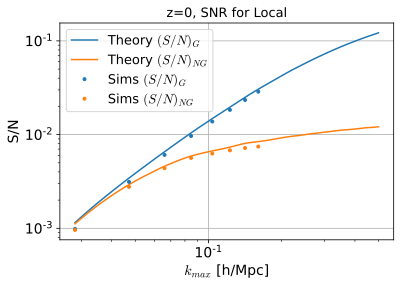

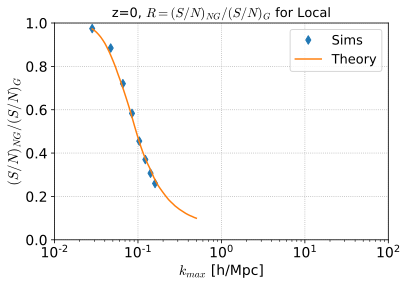

In [27]:
plt.loglog(kmaxs_full, SN2G_full**.5,label="Theory $(S/N)_{G}$")
plt.loglog(kmaxs_full, SN2NG_full**.5,label="Theory $(S/N)_{NG}$")
plt.gca().set_prop_cycle(None)
if z < 30:
    plt.loglog(kQuij,SN2G**.5,".",label="Sims $(S/N)_G$")
    plt.loglog(kQuij,SN2NG**.5,".",label="Sims $(S/N)_{NG}$")
plt.xlabel("$k_{max}$ [h/Mpc]")
plt.ylabel("S/N")
plt.title(f"z={zs[zi]}, " + "SNR for " + ShapeLabels[BShape_n],fontsize=13)
plt.grid()
# plt.legend(bbox_to_anchor=(1, 1))
plt.legend(fontsize=13)
plt.show()

if z < 30: plt.semilogx(kQuij, R_Quij,"d",label="Sims")
plt.semilogx(kmaxs_full, R_full ,label="Theory")
plt.ylabel("$(S/N)_{NG} / (S/N)_{G}$")
plt.xlabel("$k_{max}$ [h/Mpc]")
plt.grid(linestyle=":")
plt.xlim(1e-2,1e2)
plt.ylim(0,1)
plt.legend(fontsize=13)
plt.title(f"z={zs[zi]}, " + "$R = (S/N)_{NG} / (S/N)_G$ for " + ShapeLabels[BShape_n],fontsize=13)
plt.show()

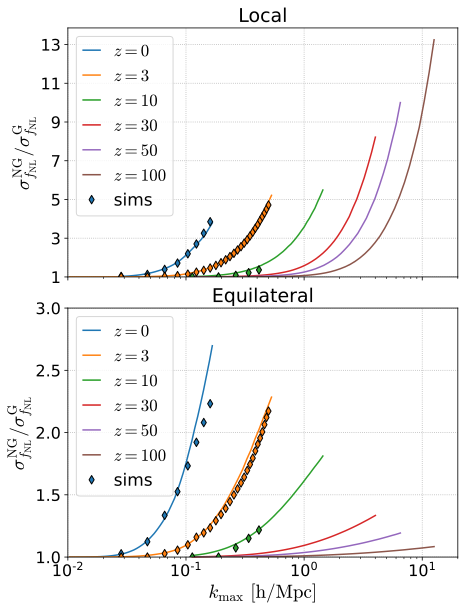

In [48]:
fig, axs = plt.subplots(2,1,sharex=True,figsize=(7,9.75))
plt.subplots_adjust(wspace=0, hspace=0.125)

ShapeNames = ["Local","Equil"]
ShapeNamesFull = ["Local","Equilateral","Orthogonal"]
zlist = [0,3,10,30,50,100]
for Si,Shapey in enumerate(ShapeNames):
    for zii, zz in enumerate(zlist):
        data = np.load(f"Results/BS_Full_{Shapey}_z{zz}.npy")
        kdat = data[:,0]
        rdat = data[:,-1]
        axs[Si].semilogx(kdat,rdat**-1)
    
    axs[Si].set_prop_cycle(None)
    
    if Shapey != "Ortho":
        for zii, zz in enumerate(zlist[:3]):
            data = np.load(f"Results/BS_Sims_{Shapey}_z{zz}.npy")
            kdat = data[:,0]
            rdat = data[:,-1]
            axs[Si].semilogx(kdat,rdat**-1,"d",markeredgecolor='black')
    
    
#     axs[Si].set_title(ShapeNamesFull[Si])
    axs[Si].grid(linestyle=":")
    if Shapey=="Local":
        axs[Si].set_yticks([1 + 2*n for n in range(7)],fontsize=19)
    if Shapey=="Equil": 
        axs[Si].set_yticks([1 + 0.5*n for n in range(5)],fontsize=19)
    axs[Si].set_ylim(1)
    axs[Si].set_ylabel("$\sigma_{f_{\\rm NL}}^{\\rm NG}/\sigma^{\\rm G}_{f_{\\rm NL}}$",fontsize=19)
    axs[Si].set_title(f"{ShapeNamesFull[Si]}",fontsize=19)
    axs[Si].legend(np.append([f"$z = {z}$" for z in zlist],"sims"),loc=2,handlelength=1,fontsize=17)

plt.xlim(1e-2,2e1)
plt.xlabel("$k_{\\rm max}$ $\\rm [h/Mpc]$",fontsize=19)
plt.savefig(f"Results/R_BS.pdf",format='pdf',bbox_inches='tight')
plt.show()

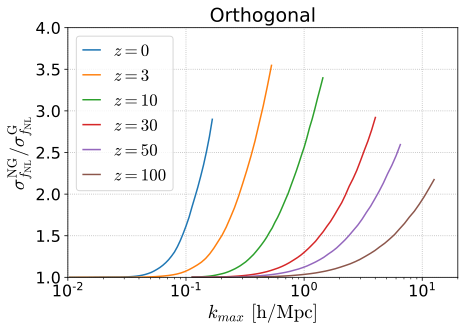

In [47]:
fig, axs = plt.subplots(1,1,sharex=True,figsize=(7,4.6))
# plt.subplots_adjust(wspace=0, hspace=0.125)

ShapeNames = ["Ortho"]
ShapeNamesFull = ["Orthogonal"]
zlist = [0,3,10,30,50,100]
for Si,Shapey in enumerate(ShapeNames):
    for zii, zz in enumerate(zlist):
        data = np.load(f"Results/BS_Full_{Shapey}_z{zz}.npy")
        kdat = data[:,0]
        rdat = data[:,-1]
        plt.semilogx(kdat,rdat**-1)
    
    # plt.set_prop_cycle(None)
    
    
    
#     axs[Si].set_title(ShapeNamesFull[Si])
    plt.grid(linestyle=":")
    plt.ylim(1,4)
    plt.yticks([1 + 0.5*n for n in range(7)])
    plt.ylabel("$\sigma_{f_{\\rm NL}}^{\\rm NG}/\sigma^{\\rm G}_{f_{\\rm NL}}$",fontsize=19)
    plt.title(f"{ShapeNamesFull[Si]}",fontsize=19)
    plt.legend(np.append([f"$z = {z}$" for z in zlist],"sims"),loc=2,handlelength=1,fontsize=17)

plt.xlim(1e-2,2e1)
plt.xlabel("$k_{max}$ $\\rm [h/Mpc]$",fontsize=19)
plt.savefig(f"Results/R_Orth.pdf",format='pdf',bbox_inches='tight')
plt.show()